In [29]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
from shapely.geometry import Point, Polygon, shape

   centroid_x  centroid_y  qh  \
0  114.143157   22.577605  罗湖   
1  114.041535   22.546180  福田   
2  114.270206   22.596432  盐田   
3  113.851387   22.679120  宝安   
4  113.926290   22.766157  光明   

                                            geometry  
0  POLYGON ((114.10006 22.53431, 114.09969 22.535...  
1  POLYGON ((113.98578 22.51348, 113.98558 22.523...  
2  POLYGON ((114.22772 22.54290, 114.22643 22.543...  
3  MULTIPOLYGON (((113.81831 22.54676, 113.81816 ...  
4  POLYGON ((113.98587 22.80304, 113.98605 22.802...  


<Axes: >

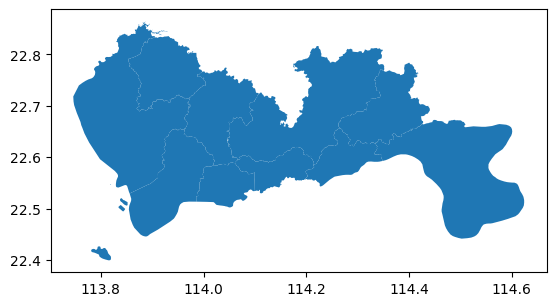

In [30]:
shp = r'../shapefile/sz.shp'
sz = gpd.GeoDataFrame.from_file(shp, encoding='utf-8')
print(sz.head())
sz.plot()

51.0 12.0 113.99800701150498 22.499547959873865 0.004872614089207591 0.004496605206422906


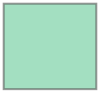

In [31]:
import math

# 测试栅格化的中心经纬度
test_lon = 114
test_lat = 22.5

# 栅格划分范围
lon1 = 113.75194
lon2 = 114.624187
lat1 = 22.447837
lat2 = 22.864748

latStart = min(lat1, lat2)
lonStart = min(lon1, lon2)
# 栅格划分尺度
accuracy = 500
deltaLon = accuracy * 360 / (2 * math.pi * 6371004 * math.cos((lat1 + lat2) * math.pi / 360))
deltaLat = accuracy * 360 / (2 * math.pi * 6371004)

# divmod: 返回一个包含商和余数的元组(a//b, a%b)
# 计算得到测试经纬度的编号
lon_div = divmod(float(test_lon)-(lonStart-deltaLon/2), deltaLon)[0]
lat_div = divmod(float(test_lat)-(latStart-deltaLat/2), deltaLat)[0]
# 计算中心块的中心经纬度
lon_cent = lon_div * deltaLon + (lonStart - deltaLon/2)
lat_cent = lat_div * deltaLat + (latStart - deltaLat/2)

print(lon_div, lat_div, lon_cent, lat_cent, deltaLon, deltaLat)

# 根据计算数据构建栅格的geopandas数据
from shapely.geometry import Polygon
Polygon([
    (lon_cent+deltaLon/2, lat_cent-deltaLat/2),
    (lon_cent+deltaLon/2, lat_cent+deltaLat/2),
    (lon_cent-deltaLon/2, lat_cent+deltaLat/2),
    (lon_cent-deltaLon/2, lat_cent-deltaLat/2)
])

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Polygon

data = geopandas.GeoDataFrame()
lon_num = int((lon2-lon1)/deltaLon) + 1
lat_num = int((lat2-lat1)/deltaLat) + 1
index_lat = []
index_lon = []
cent_lat = []
cent_lon = []
geometry = []
for i in range(lon_num):
    for j in range(lat_num):
        index_lon.append(i)
        index_lat.append(j)
        # 当前块的中心
        temp_cent_lat = j*deltaLat + (latStart-deltaLat/2)
        temp_cent_lon = i*deltaLon + (lonStart-deltaLon/2)
        # 下一个块的中心
        temp_cent_lon_1 = (i+1)*deltaLon + (lonStart-deltaLon/2)
        temp_cent_lat_1 = (j+1)*deltaLat + (latStart-deltaLat/2)
        cent_lat.append(temp_cent_lat)
        cent_lon.append(temp_cent_lon)
        geometry.append(Polygon([
            (temp_cent_lon-deltaLon/2, temp_cent_lat-deltaLat/2),
            (temp_cent_lon_1-deltaLon/2, temp_cent_lat-deltaLat/2),
            (temp_cent_lon_1-deltaLon/2, temp_cent_lat_1-deltaLat/2),
            (temp_cent_lon-deltaLon/2, temp_cent_lat_1-deltaLat/2)
        ]))
data['index_lon'] = index_lon
data['index_lat'] = index_lat
data['cent_lon'] = cent_lon
data['cent_lat'] = cent_lat
data['geometry'] = geometry   
data.head()

C:\Users\Beck\AppData\Local\Temp\ipykernel_14856\3903777751.py:37: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  data['geometry'] = geometry


,index_lon,index_lat,cent_lon,cent_lat,geometry
0,0,0,113.749504,22.445589,"POLYGON ((113.74707 22.44334, 113.75194 22.443..."
1,0,1,113.749504,22.450085,"POLYGON ((113.74707 22.44784, 113.75194 22.447..."
2,0,2,113.749504,22.454582,"POLYGON ((113.74707 22.45233, 113.75194 22.452..."
3,0,3,113.749504,22.459079,"POLYGON ((113.74707 22.45683, 113.75194 22.456..."
4,0,4,113.749504,22.463575,"POLYGON ((113.74707 22.46133, 113.75194 22.461..."


<Axes: >

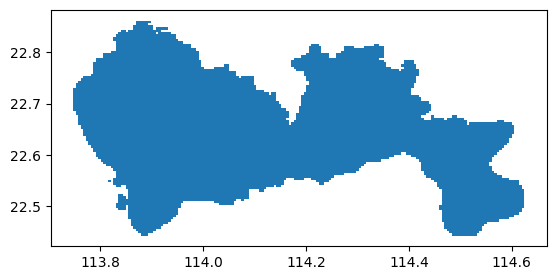

In [33]:
grid = data[data.intersects(sz.unary_union)]
grid.plot()

In [34]:
import pandas as pd
TaxiOD = pd.read_csv(r'../data-sample/TaxiOD.csv')
TaxiOD.columns = [
    'VehicleNum', 'Stime', 'SLng', 'SLat', 'ELng', 'ELat', 'Etime'
]
TaxiOD.head()

,VehicleNum,Stime,SLng,SLat,ELng,ELat,Etime
0,22223,00:03:23,114.167465,22.562468,114.225235,22.552750,00:10:48
1,22223,00:11:33,114.227150,22.554167,114.229218,22.560217,00:15:19
2,22223,00:17:13,114.231354,22.562166,114.255798,22.590967,00:29:06
3,22223,00:36:45,114.240196,22.563650,114.119965,22.566668,00:54:42
4,22223,01:01:14,114.135414,22.575933,114.166748,22.608267,01:08:17


In [35]:
# 去除空值
TaxiOD = TaxiOD[-TaxiOD['ELng'].isnull()].copy()
TaxiOD['SLONCOL'] = ((TaxiOD['SLng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
TaxiOD['SLATCOL'] = ((TaxiOD['SLat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
TaxiOD['SHBLON'] = TaxiOD['SLONCOL']*deltaLon + (lonStart - deltaLon / 2)
TaxiOD['SHBLAT'] = TaxiOD['SLATCOL']*deltaLat + (latStart - deltaLat / 2)
TaxiOD['ELONCOL'] = ((TaxiOD['ELng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
TaxiOD['ELATCOL'] = ((TaxiOD['ELat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
TaxiOD['EHBLON'] = TaxiOD['ELONCOL']*deltaLon + (lonStart - deltaLon / 2)
TaxiOD['EHBLAT'] = TaxiOD['ELATCOL']*deltaLat + (latStart - deltaLat / 2)
#筛选去掉起点终点在同一个格子里的OD
TaxiOD = TaxiOD[-((TaxiOD['SLONCOL']==TaxiOD['ELONCOL'])&(TaxiOD['SLATCOL']==TaxiOD['ELATCOL']))]
#筛选去掉不在研究范围内的栅格
TaxiOD = TaxiOD[(TaxiOD['SLONCOL']>=0) & (TaxiOD['SLATCOL']>=0) &(TaxiOD['ELONCOL']>=0) & (TaxiOD['ELATCOL']>=0)&
(TaxiOD['SLONCOL']<=lon_num) & (TaxiOD['SLATCOL']<=lat_num) &(TaxiOD['ELONCOL']<=lon_num) & (TaxiOD['ELATCOL']<=lat_num)]
###################################################################################
TaxiOD.head(5)

,VehicleNum,Stime,SLng,SLat,ELng,ELat,Etime,SLONCOL,SLATCOL,SHBLON,SHBLAT,ELONCOL,ELATCOL,EHBLON,EHBLAT
0,22223,00:03:23,114.167465,22.562468,114.225235,22.552750,00:10:48,85,25,114.163676,22.558004,97,23,114.222147,22.549011
1,22223,00:11:33,114.227150,22.554167,114.229218,22.560217,00:15:19,98,24,114.227020,22.553507,98,25,114.227020,22.558004
2,22223,00:17:13,114.231354,22.562166,114.255798,22.590967,00:29:06,98,25,114.227020,22.558004,103,32,114.251383,22.589480
3,22223,00:36:45,114.240196,22.563650,114.119965,22.566668,00:54:42,100,26,114.236765,22.562500,76,26,114.119822,22.562500
4,22223,01:01:14,114.135414,22.575933,114.166748,22.608267,01:08:17,79,28,114.134440,22.571494,85,36,114.163676,22.607466


In [42]:
from shapely.geometry import LineString
# 取得栅格内的车辆数目
# groupby中的列都会变成index
OD = TaxiOD.groupby([
    'SLONCOL', 'SLATCOL', 'ELONCOL', 'ELATCOL'
])['VehicleNum'].count().reset_index()
OD = OD.sort_values(by='VehicleNum', ascending=False)
OD['geometry'] = OD.apply(lambda r : LineString([
    [r['SLONCOL'] * deltaLon + (lonStart-deltaLon/2),
    r['SLATCOL'] * deltaLat + (latStart-deltaLat/2)],
    [r['ELONCOL'] * deltaLon + (lonStart-deltaLon/2),
    r['ELATCOL'] * deltaLat + (latStart-deltaLat/2)]
]), axis=1)
OD = gpd.GeoDataFrame(OD)
OD.head()

,SLONCOL,SLATCOL,ELONCOL,ELATCOL,VehicleNum,geometry
113365,63,17,65,16,298,"LINESTRING (114.05648 22.52203, 114.06622 22.5..."
155022,75,21,74,19,275,"LINESTRING (114.11495 22.54002, 114.11008 22.5..."
113808,63,18,65,16,235,"LINESTRING (114.05648 22.52653, 114.06622 22.5..."
160281,76,21,74,19,173,"LINESTRING (114.11982 22.54002, 114.11008 22.5..."
122609,65,17,63,18,172,"LINESTRING (114.06622 22.52203, 114.05648 22.5..."


In [37]:
Topod = OD.iloc[:20].copy()

Topod['SHBLON'] = Topod['SLONCOL'] * deltaLon + (lonStart-deltaLon/2)
Topod['SHBLAT'] = Topod['SLATCOL'] * deltaLat + (latStart-deltaLat/2)
Topod['EHBLON'] = Topod['ELONCOL'] * deltaLon + (lonStart-deltaLon/2)
Topod['EHBLAT'] = Topod['ELATCOL'] * deltaLat + (latStart-deltaLat/2)

Topod.head()

,SLONCOL,SLATCOL,ELONCOL,ELATCOL,VehicleNum,geometry,SHBLON,SHBLAT,EHBLON,EHBLAT
113365,63,17,65,16,298,LINESTRING (114.0564783805755 22.5220309859059...,114.056478,22.522031,114.066224,22.517534
155022,75,21,74,19,275,LINESTRING (114.114949749646 22.54001740673167...,114.114950,22.540017,114.110077,22.531024
113808,63,18,65,16,235,LINESTRING (114.0564783805755 22.5265275911124...,114.056478,22.526528,114.066224,22.517534
160281,76,21,74,19,173,LINESTRING (114.1198223637352 22.5400174067316...,114.119822,22.540017,114.110077,22.531024
122609,65,17,63,18,172,LINESTRING (114.0662236087539 22.5220309859059...,114.066224,22.522031,114.056478,22.526528


C:\Users\Beck\AppData\Local\Temp\ipykernel_14856\4226192462.py:13: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  SZ_all['geometry'] = [sz.unary_union]


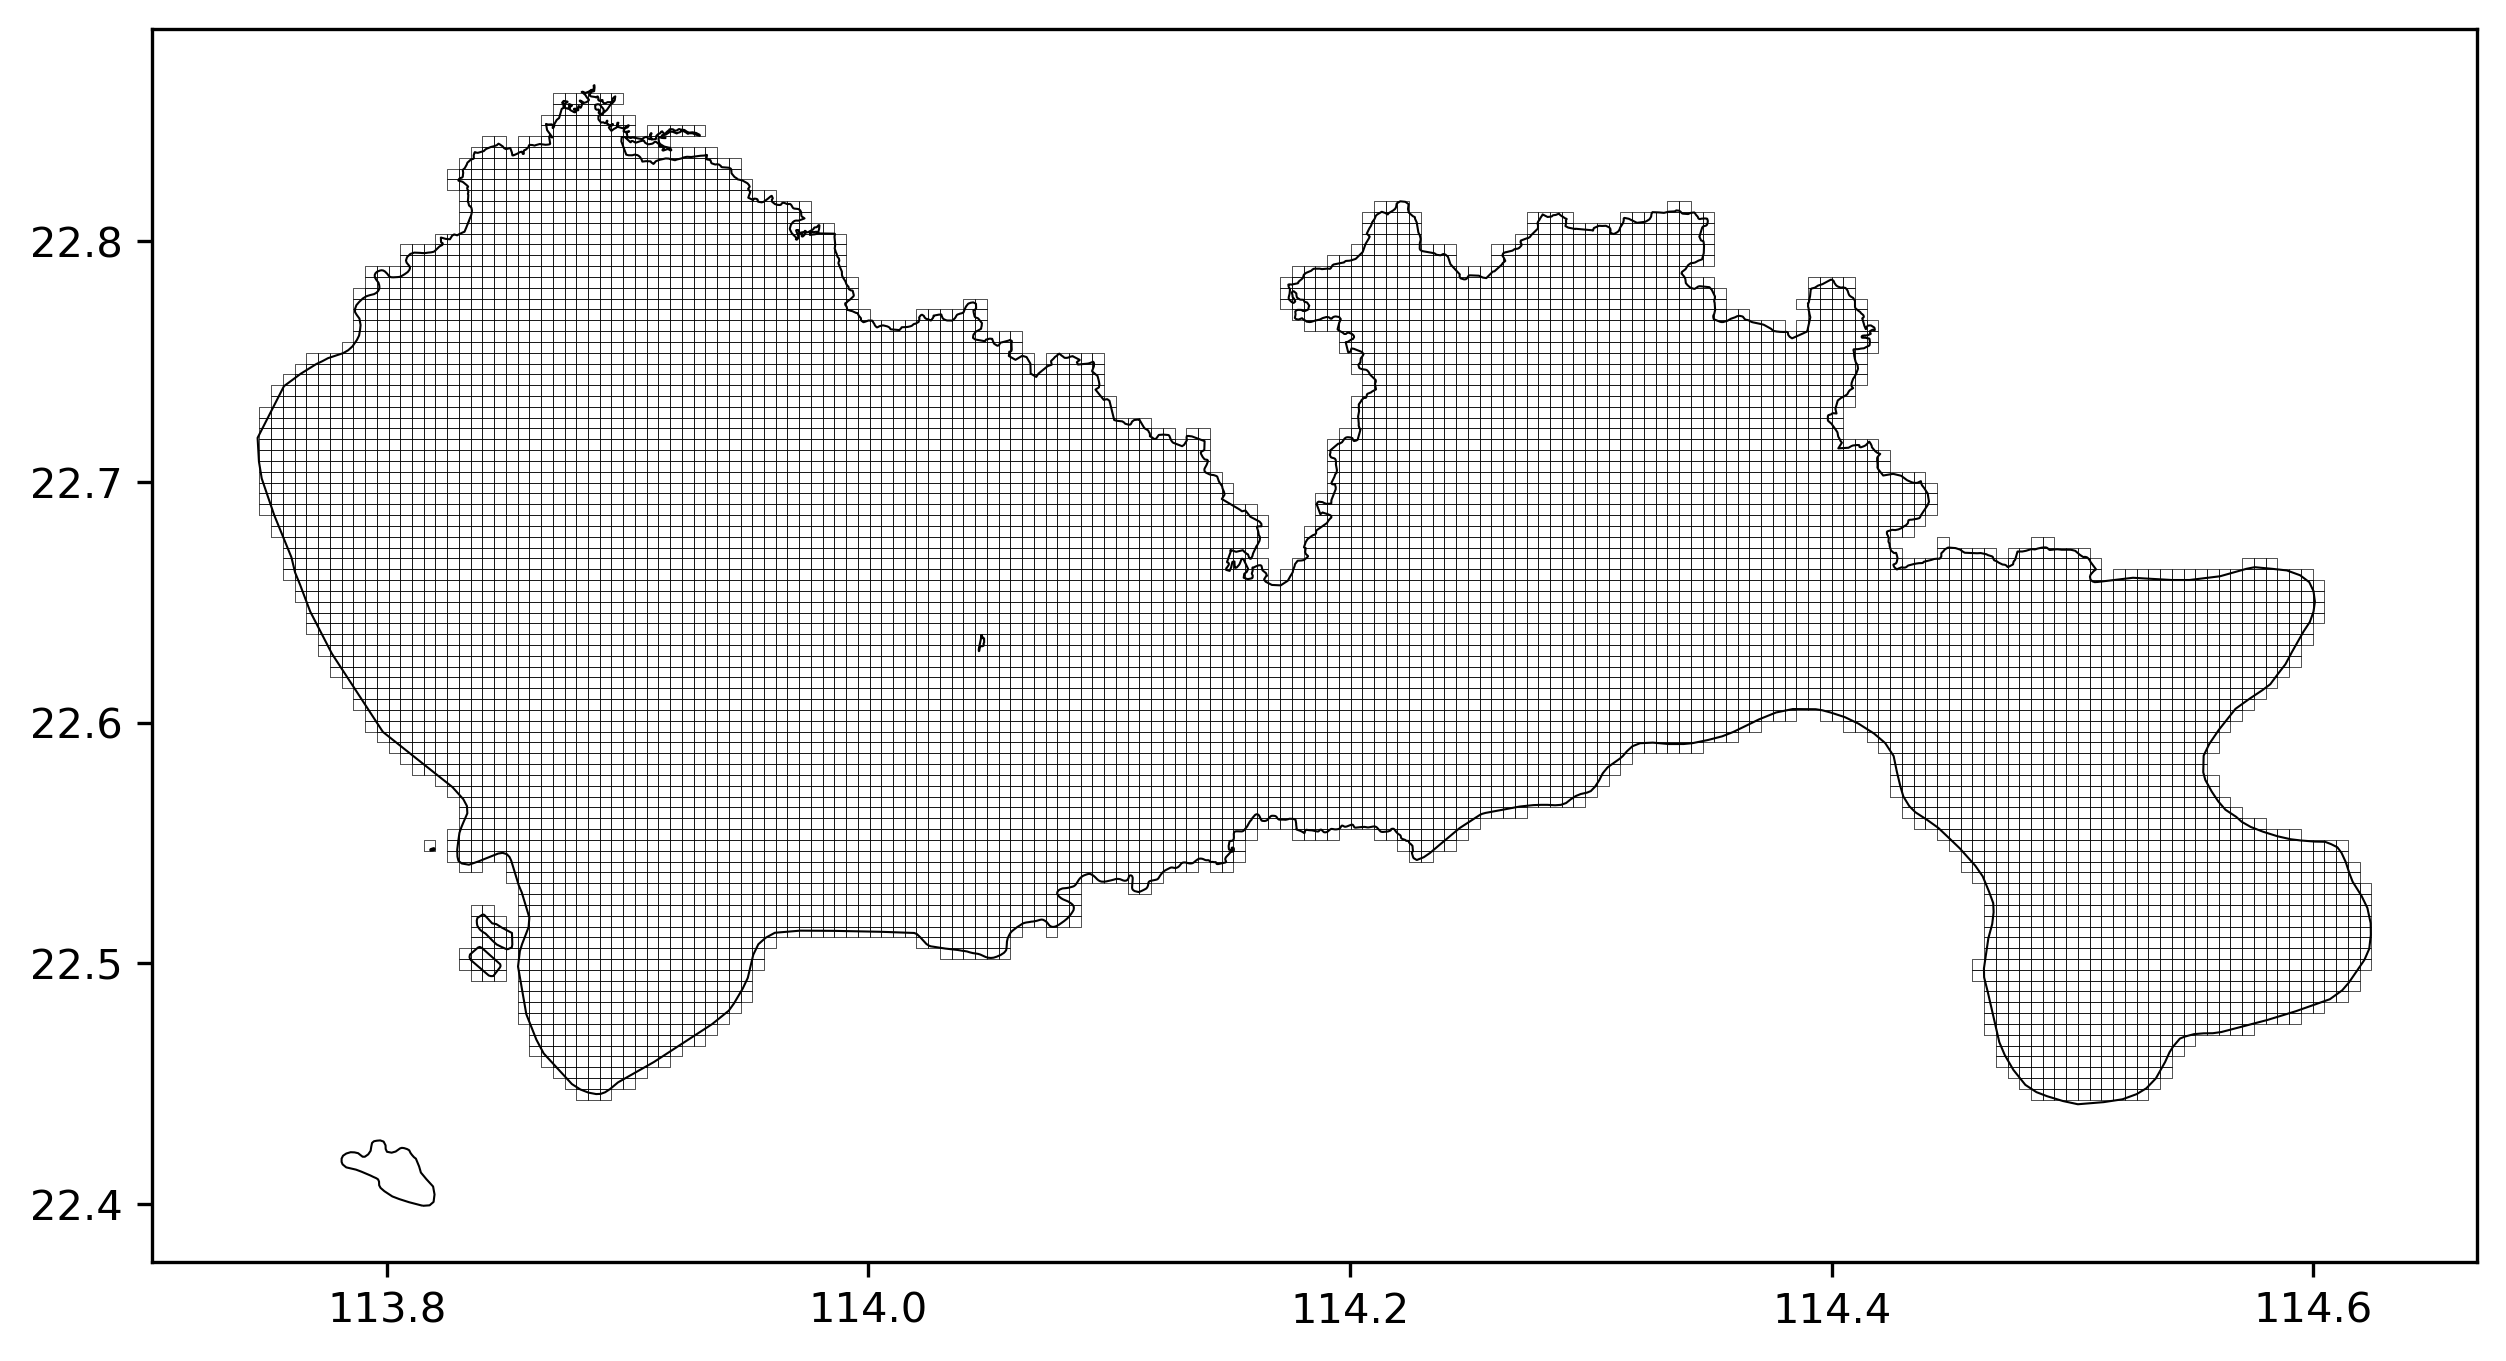

In [38]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig = plt.figure(1, (10, 8), dpi=300)
ax = plt.subplot(111)
plt.sca(ax)

#把刚才生成的栅格在ax上绘制
grid.plot(ax =ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)

#把合并的行政区划变成一个geopandas，在ax上绘制
SZ_all = geopandas.GeoDataFrame()
SZ_all['geometry'] = [sz.unary_union]
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)

plt.show()

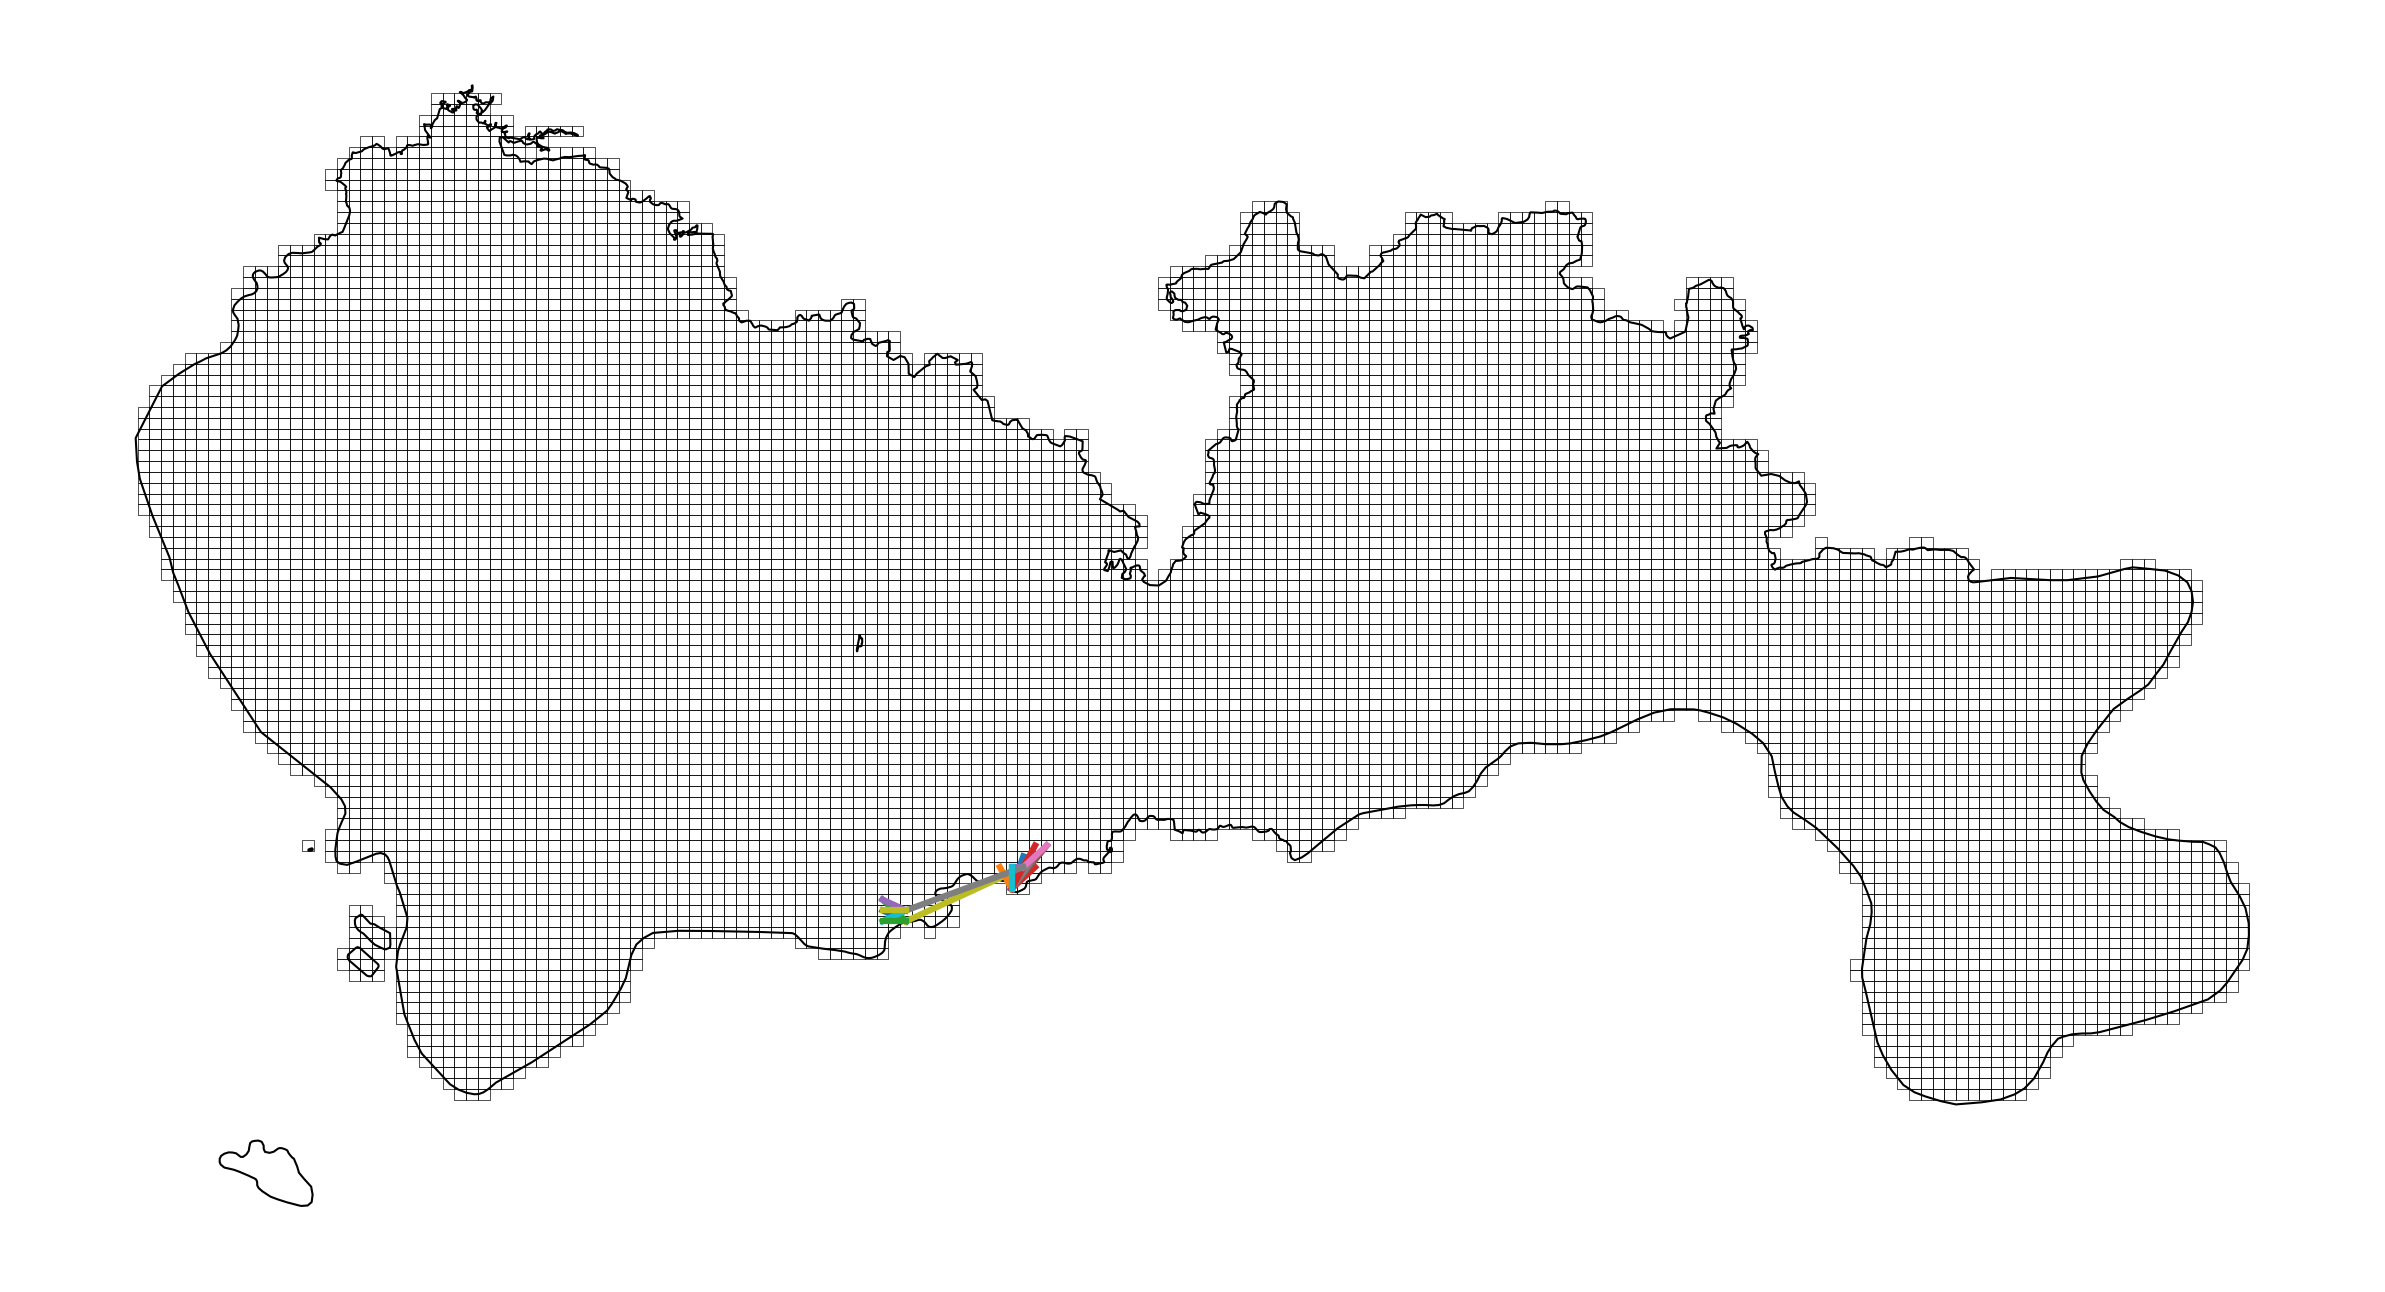

In [39]:
fig = plt.figure(1, (10, 8), dpi=300)
ax = plt.subplot(111)
# ax图设置为父图
plt.sca(ax)
# edgecolor: 图形边缘颜色
# facecolor: 柱形图填充颜色
grid.plot(ax=ax, edgecolor=(0, 0, 0, 0.8), facecolor=(0, 0, 0, 0), linewidths=0.2)
SZ_all.plot(ax=ax, edgecolor=(0, 0, 0, 1), facecolor=(0, 0, 0, 0), linewidth=0.5)

for i in range(len(Topod)):
    plt.plot([Topod['SHBLON'].iloc[i],Topod['EHBLON'].iloc[i]],[Topod['SHBLAT'].iloc[i],Topod['EHBLAT'].iloc[i]])

plt.axis('off')
plt.show()


C:\Users\Beck\AppData\Local\Temp\ipykernel_14856\4277087674.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(cmapname)


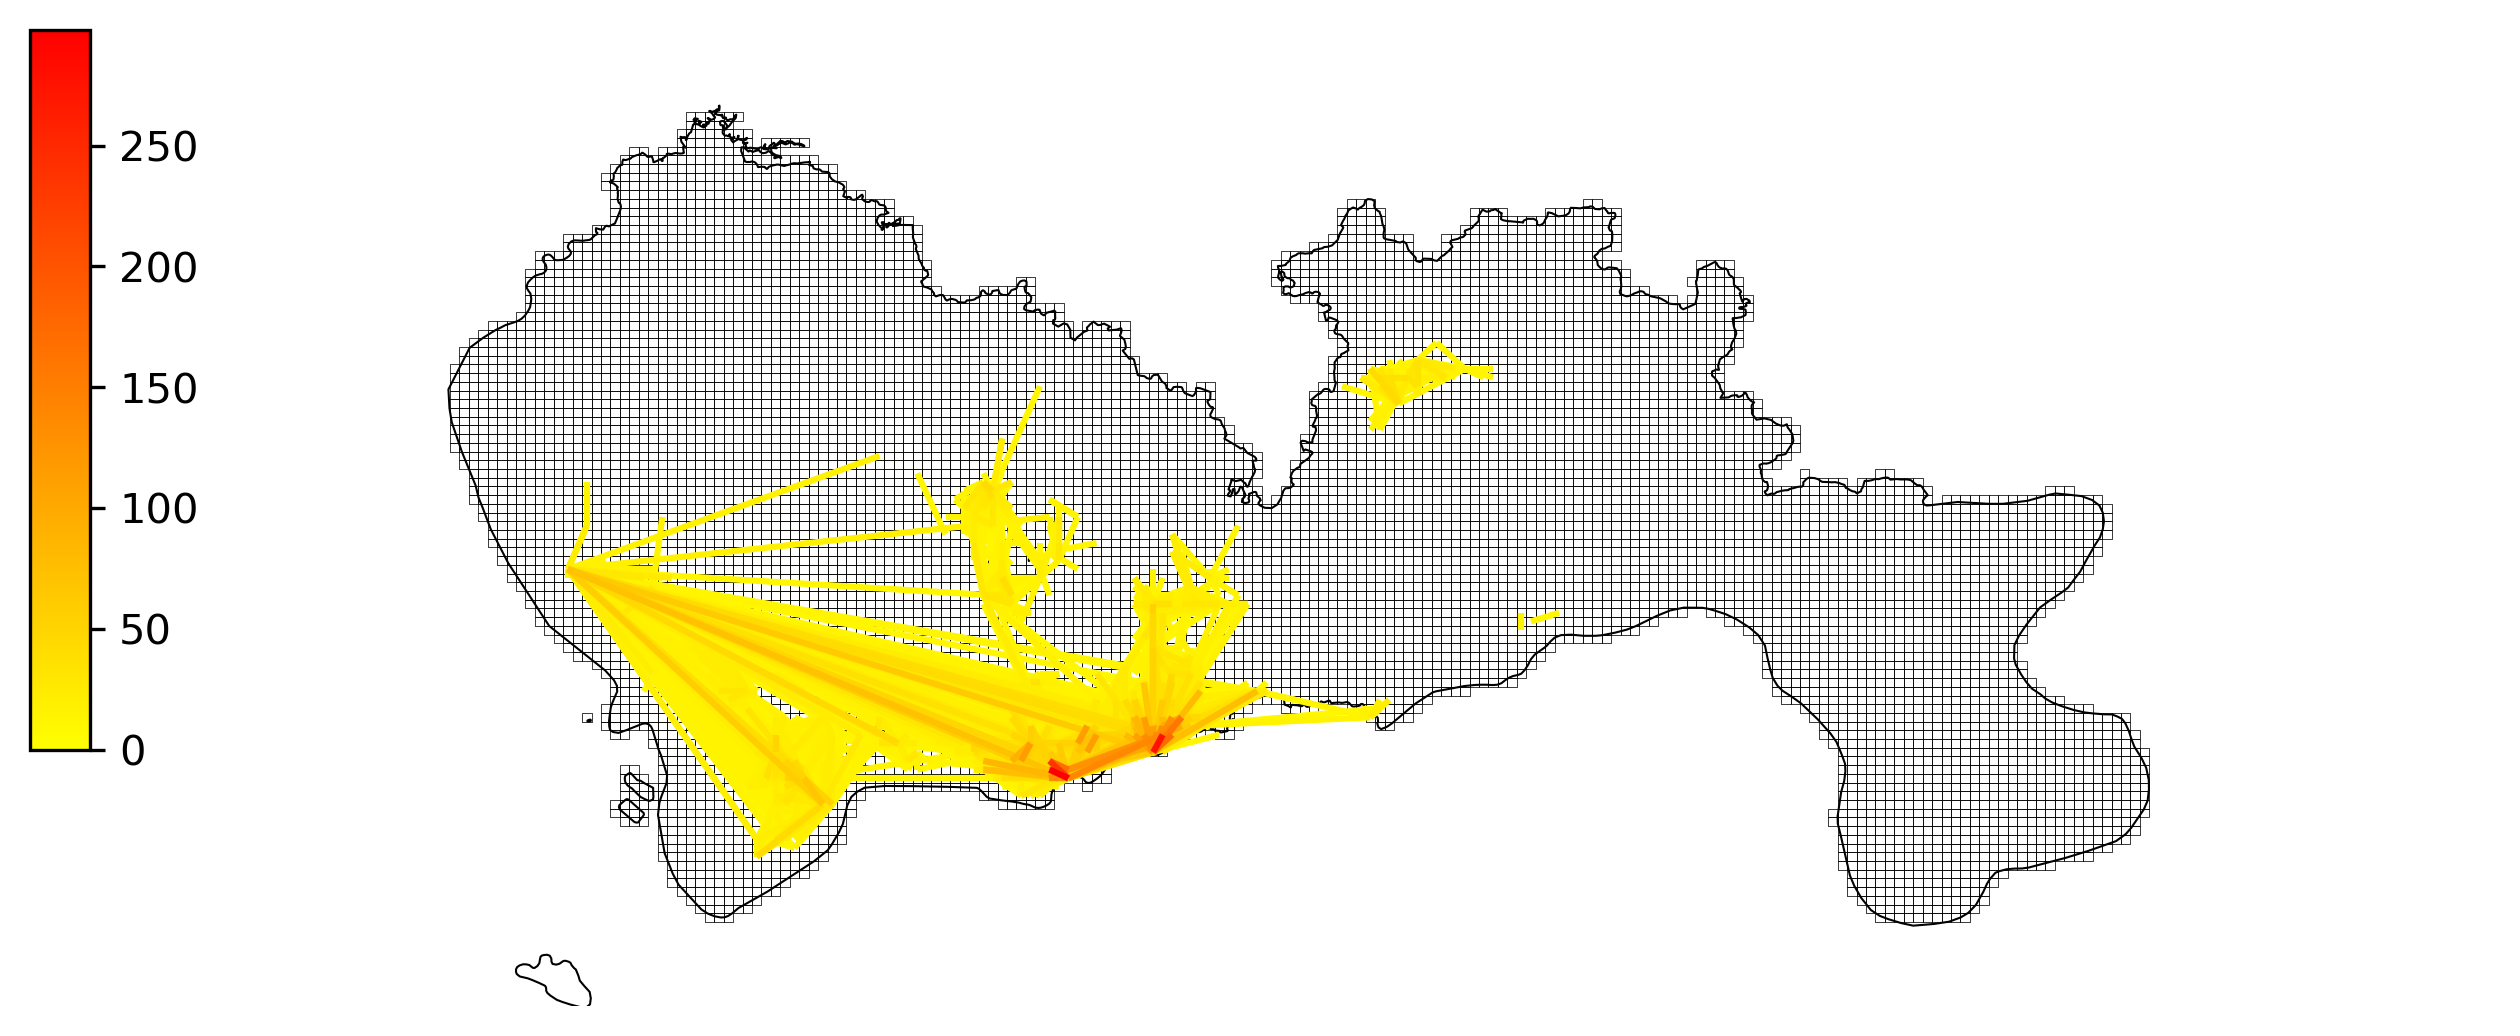

In [49]:
# 筛选合适的OD，设定阈值
OD1 = OD[OD['VehicleNum']>10].copy()
# 使得较大的值能后绘制，避免被覆盖
OD1 = OD1.sort_values(by='VehicleNum')

fig = plt.figure(1, (10, 8), dpi=300)
ax = plt.subplot(111)
plt.sca(ax)

# 绘制栅格
grid.plot(ax=ax, facecolor=(0, 0, 0, 0), edgecolor=(0, 0, 0, 0.9), linewidth=0.2)
# 绘制地图边缘
SZ_all.plot(ax=ax, edgecolor=(0, 0, 0, 1), facecolor=(0, 0, 0, 0), linewidth=0.5)
# 设置colormap
vmax = OD1['VehicleNum'].max()
cmapname = 'autumn_r'
cmap = matplotlib.cm.get_cmap(cmapname)
OD1.plot(ax=ax, column='VehicleNum', vmax=vmax, vmin=0, cmap=cmap)

plt.axis('off')

# 绘制伪图，用于cmap标注
plt.imshow([[0, vmax]], cmap=cmap)
cax = plt.axes([0.08, 0.4, 0.02, 0.3])
plt.colorbar(cax=cax)

ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)

plt.show()

C:\Users\Beck\AppData\Local\Temp\ipykernel_14856\407449638.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapname = matplotlib.cm.get_cmap('autumn_r')


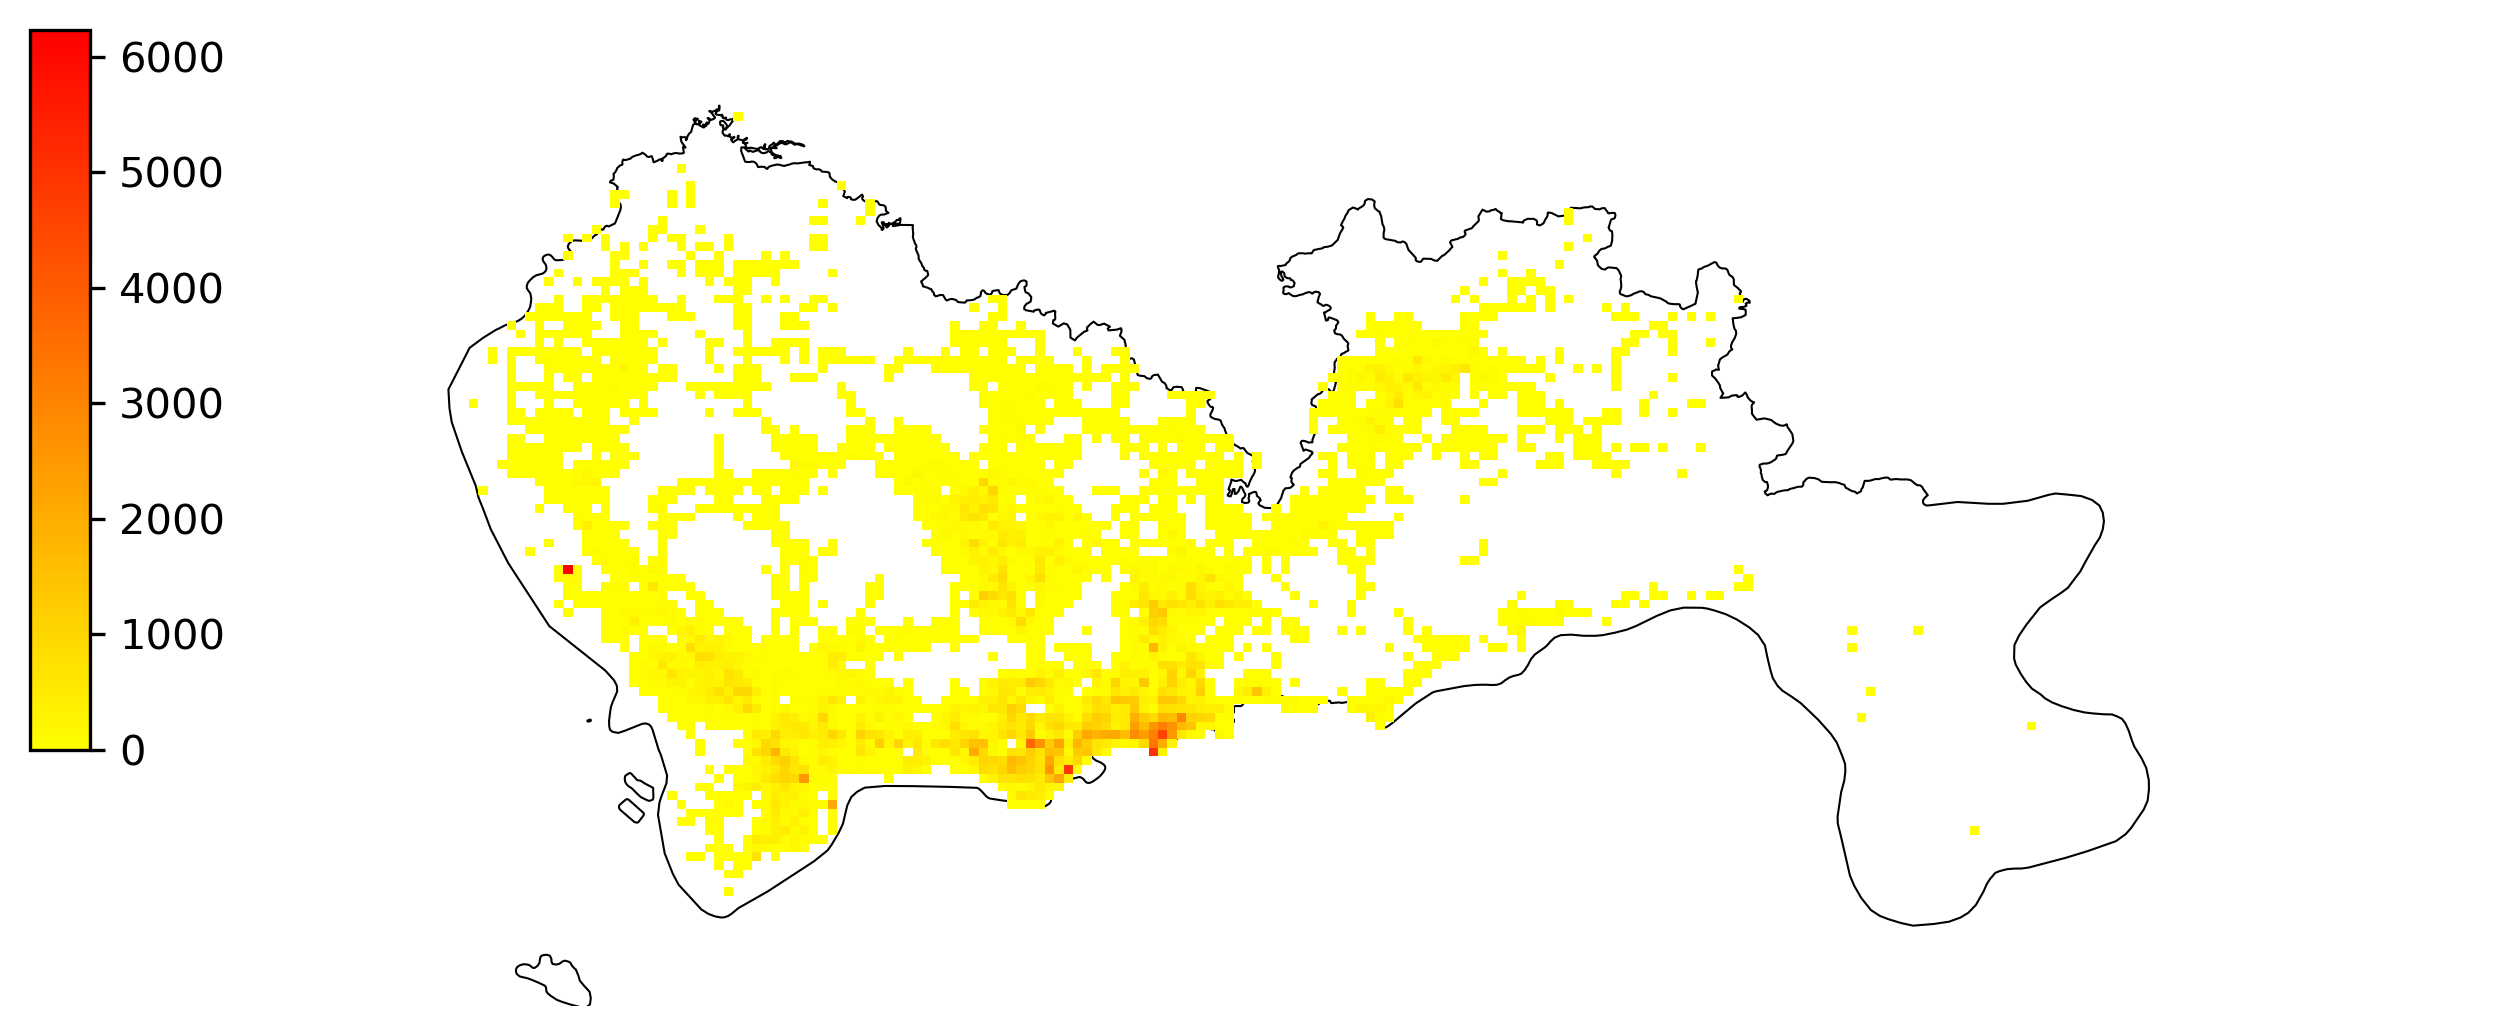

In [64]:
# 统计起始点
Odistribution = OD.groupby(['SLONCOL', 'SLATCOL'])['VehicleNum'].sum().reset_index()
# 使用merge方法进行合并
Odistribution = Odistribution.rename(columns={
    'SLONCOL': 'index_lon',
    'SLATCOL': 'index_lat'
})
gridtoplot = pd.merge(grid, Odistribution, on=['index_lon', 'index_lat'])
# 绘图
import matplotlib
fig = plt.figure(1, (10, 8), dpi=300)
ax = plt.subplot(111)
plt.sca(ax)

vmax = gridtoplot['VehicleNum'].max()
# norm = mpl.colors.Normalize(vim=0, vmax=vmax)
cmapname = matplotlib.cm.get_cmap('autumn_r')
SZ_all.plot(ax=ax, edgecolor=(0, 0, 0, 1), facecolor=(0, 0, 0, 0), linewidths=0.5)

gridtoplot.plot(ax=ax, column='VehicleNum', vmin=0, vmax=vmax, cmap=cmap)
plt.axis('off')
# 绘制用于cmap的伪图
plt.imshow([[0, vmax]], cmap=cmap)
cax = plt.axes([0.08, 0.4, 0.02, 0.3])
plt.colorbar(cax=cax)
# 坐标轴重置
ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)

plt.show()